In [13]:
#First, import all the necessary libraries into our notebook. LibROSA and SciPy are the Python libraries used for 
# processing audio signals.
import os
import librosa   #for audio processing
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import wavfile #for audio processing
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
#TensorFlow recently released the Speech Commands Datasets. It includes 65,000 one-second long utterances of 30 short
#words, by thousands of different people. We’ll build a speech recognition system that understands simple spoken 
#commands.

In [14]:
dataset = pd.read_csv('XFull_Bengali.csv')
dataset.head()


,1,2,3,4,5,6,7,8,9,10,...,1852,1853,1854,1855,1856,1857,1858,1859,1860,Label
0,-1.0424,-1.09460,-1.14160,-1.17170,-1.09490,-1.08050,-1.04750,-1.0387,-1.0650,-1.09530,...,1.10440,1.10440,1.10440,1.10440,1.10440,1.10440,1.10440,1.10440,1.10440,tin
1,0.5554,0.55540,0.55540,0.55540,0.55540,0.55540,0.55540,0.5554,0.5554,0.55540,...,0.55576,0.55576,0.55576,0.55576,0.55576,0.55576,0.55576,0.55576,0.55576,aat
2,-1.2299,-0.84431,-0.74205,-0.69578,-0.83158,-0.78374,-0.65759,-0.5981,-0.5396,-0.66768,...,0.42032,0.57954,0.66233,0.41518,-0.61920,3.51810,3.51810,3.51810,3.51810,choy
3,-1.8571,-1.80920,-1.72940,-1.65110,-1.65250,-1.65760,-1.68840,-1.6937,-1.6903,-1.71670,...,0.53253,0.53253,0.53253,0.53253,0.53253,0.53253,0.53253,0.53253,0.53253,ek
4,-1.4353,-1.41590,-1.44760,-1.48050,-1.52590,-1.56820,-1.59460,-1.5683,-1.4930,-1.40910,...,0.60578,0.60578,0.60578,0.60578,0.60578,0.60578,0.60578,0.60578,0.60578,dui


In [15]:
X = dataset.iloc[:, 0:1860].values
X.shape

(13554, 1860)

In [16]:
y = dataset.iloc[:,1860].values
y.shape

(13554,)

In [17]:
import statistics
import time
from sklearn.model_selection import train_test_split
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

In [18]:
#Convert the output labels to integer encoded:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y=le.fit_transform(y)
classes= list(le.classes_)

In [19]:
#Now, convert the integer encoded labels to a one-hot vector since it is a multi-classification problem:
train_audio_path = './one_sec_data'  
labels=os.listdir(train_audio_path)
from keras.utils import np_utils
y=np_utils.to_categorical(y, num_classes=len(labels))

In [20]:
all_wave = np.array(X).reshape(-1,1860,1)
all_wave.shape
#len(all_wave[0]

(13554, 1860, 1)

In [25]:
#Split into train and validation set
#Next, we will train the model on 80% of the data and validate on the remaining 20%:
import statistics
import time
from sklearn.model_selection import train_test_split
#start_train= time.time()
x_tr, x_val, y_tr, y_val = train_test_split(np.array(all_wave),np.array(y),stratify=y,test_size = 0.2,random_state=777,shuffle=True)
#end_train = time.time()
#print(f"Train_time: {end_train-start_train}")

In [22]:
#Model Architecture for this problem
#We will build the speech-to-text model using conv1d. Conv1d is a convolutional neural network which performs the convolution along only one dimension. 
# https://www.analyticsvidhya.com/blog/2019/07/learn-build-first-speech-to-text-model-python/
from keras.layers import Dense, Dropout, Flatten, Conv1D, Input, MaxPooling1D
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
K.clear_session()

inputs = Input(shape=(1860,1))

#First Conv1D layer
conv = Conv1D(8,15, padding='valid', activation='relu', strides=1)(inputs)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Second Conv1D layer
conv = Conv1D(16, 13, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Third Conv1D layer
conv = Conv1D(32, 11, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Fourth Conv1D layer
conv = Conv1D(64, 9, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Fifth Conv1D layer
#conv = Conv1D(128, 3, padding='valid', activation='relu', strides=1)(conv)
#conv = MaxPooling1D(3)(conv)
#conv = Dropout(0.3)(conv)
#Flatten layer
conv = Flatten()(conv)

#Dense Layer 1
conv = Dense(128, activation='relu')(conv)
conv = Dropout(0.3)(conv)

#Dense Layer 2
conv = Dense(64, activation='relu')(conv)
conv = Dropout(0.3)(conv)

outputs = Dense(len(labels), activation='softmax')(conv)

model = Model(inputs, outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1860, 1)]         0         
                                                                 
 conv1d (Conv1D)             (None, 1846, 8)           128       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 615, 8)           0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 615, 8)            0         
                                                                 
 conv1d_1 (Conv1D)           (None, 603, 16)           1680      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 201, 16)          0         
 1D)                                                         

In [23]:
#Define the loss function to be categorical cross-entropy since it is a multi-classification problem:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [24]:
#Early stopping and model checkpoints are the callbacks to stop training the neural network at the right time and 
# to save the best model after every epoch:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, min_delta=0.0001) 
mc = ModelCheckpoint('best_model.hdf5', monitor='val_acc', verbose=1, save_best_only=True, mode='max')

In [26]:
# Let us train the model on a batch size of 32 and evaluate the performance on the holdout set:
start_train= time.time()
history=model.fit(x_tr, y_tr ,epochs=50, callbacks=[es,mc], batch_size=32, validation_data=(x_val,y_val))
end_train = time.time()
print(f"Train_time: {end_train-start_train}")

Epoch 1/50
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
338/339 [============================>.] - ETA: 0s - loss: 2.1775 - accuracy: 0.1729WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x00000035047E2288> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`

Epoch 22/50
339/339 [==============================] - 15s 43ms/step - loss: 0.2383 - accuracy: 0.9248 - val_loss: 0.0908 - val_accuracy: 0.9753
Epoch 23/50
339/339 [==============================] - 14s 42ms/step - loss: 0.2293 - accuracy: 0.9267 - val_loss: 0.0941 - val_accuracy: 0.9731
Epoch 24/50
339/339 [==============================] - 15s 43ms/step - loss: 0.2131 - accuracy: 0.9338 - val_loss: 0.0947 - val_accuracy: 0.9753
Epoch 25/50
339/339 [==============================] - 15s 43ms/step - loss: 0.2102 - accuracy: 0.9333 - val_loss: 0.1091 - val_accuracy: 0.9664
Epoch 26/50
339/339 [==============================] - 15s 43ms/step - loss: 0.2047 - accuracy: 0.9352 - val_loss: 0.0747 - val_accuracy: 0.9775
Epoch 27/50
339/339 [==============================] - 15s 45ms/step - loss: 0.2025 - accuracy: 0.9365 - val_loss: 0.0829 - val_accuracy: 0.9771
Epoch 28/50
339/339 [==============================] - 15s 45ms/step - loss: 0.1865 - accuracy: 0.9410 - val_loss: 0.0744 - val_ac

Epoch 49/50
339/339 [==============================] - 14s 42ms/step - loss: 0.1369 - accuracy: 0.9572 - val_loss: 0.0657 - val_accuracy: 0.9834
Epoch 50/50
339/339 [==============================] - 15s 44ms/step - loss: 0.1406 - accuracy: 0.9547 - val_loss: 0.0569 - val_accuracy: 0.9812
Train_time: 767.1192300319672


In [27]:
import pickle
import sys

p = pickle.dumps(model)
print(sys.getsizeof(p)/1024) #KB

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity t

In [17]:
model.save('best_model_bengali_full.hdf5')

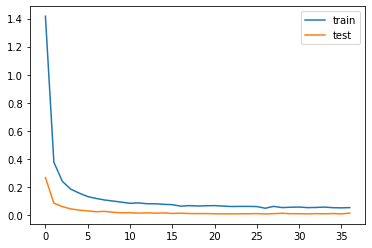

In [46]:
#I’m going to lean on visualization again to understand the performance of the model over a period of time:
from matplotlib import pyplot 
pyplot.plot(history.history['loss'], label='train') 
pyplot.plot(history.history['val_loss'], label='test') 
pyplot.legend() 
pyplot.show()

In [19]:
#Loading the best model
from keras.models import load_model
model=load_model('best_model_bengali_full.hdf5')

In [26]:
#define the function that predicts text for the given audio:
def predict(audio):
    prob=model.predict(audio.reshape(1,8000,1))
    index=np.argmax(prob[0])
    return classes[index]

In [28]:
#Prediction time! Make predictions on the validation data:
import random
index=random.randint(0,len(x_val)-1)
samples=x_val[index].ravel()
print("Audio:",classes[np.argmax(y_val[index])])
ipd.Audio(samples, rate=8000)
print("Text:",predict(samples))

Audio: tin
Text: tin


In [35]:
#The best part is yet to come! Here is a script that prompts a user to record voice commands. 
#Record your own voice commands and test it on the model:
import sounddevice as sd
import soundfile as sf

samplerate = 16000  
duration = 1 # seconds
filename = 'yes.wav'
print("start")
mydata = sd.rec(int(samplerate * duration), samplerate=samplerate,
    channels=1, blocking=True)
print("end")
sd.wait()
sf.write(filename, mydata, samplerate)

start
end


In [34]:
#Let us now read the saved voice command and convert it to text:
os.listdir('./voice-commands')
filepath='./voice-commands'

#reading the voice commands
samples, sample_rate = librosa.load(filepath + '/' + 'yes.wav', sr = 16000)
samples = librosa.resample(samples, sample_rate, 8000)
ipd.Audio(samples,rate=8000) 



In [36]:
predict(samples)

'choy'

In [37]:
samples, sample_rate = librosa.load(filename, sr = 16000)
samples = librosa.resample(samples, sample_rate, 8000)
ipd.Audio(samples,rate=8000) 

In [38]:
predict(samples)

'sunno'

In [20]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(x_val, y_val, batch_size=8)  #saved_model
print("test loss, test acc:", results)

Evaluate on test data
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
339/339 [==============================] - 2s 4ms/step - loss: 0.0566 - accuracy: 0.9838
test loss, test acc: [0.056606050580739975, 0.9837698340415955]


In [21]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

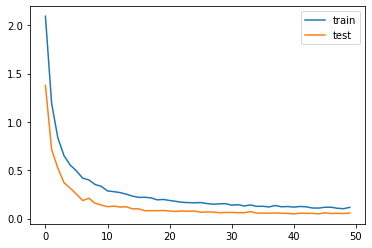

In [22]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

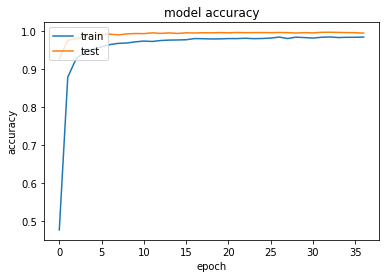

In [47]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [24]:
import tensorflow as tf
y_predict=model.predict(x_val)
conf_mat=tf.math.confusion_matrix(np.argmax(y_val,axis=1) , np.argmax(y_predict,axis=1))

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


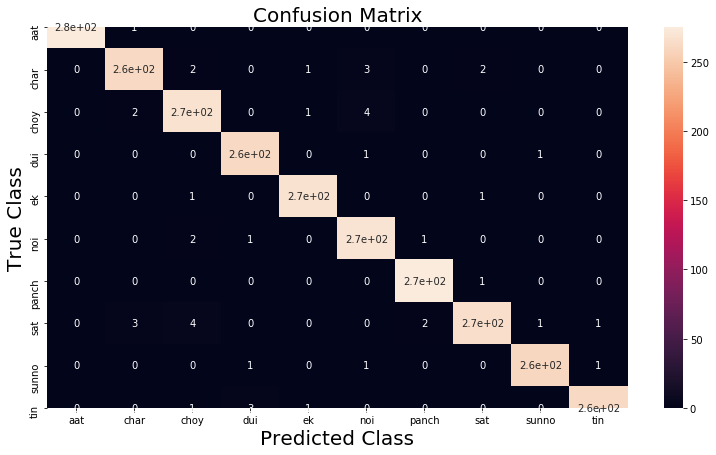

In [25]:
import seaborn as sn
import pandas as pd
df_cm = pd.DataFrame(np.array(conf_mat), index = [i for i in classes],
                  columns = [i for i in classes])
plt.figure(figsize = (13,7))
ax = sn.heatmap(df_cm, annot=True)
plt.title("Confusion Matrix", fontsize=20)
plt.ylabel("True Class"     , fontsize=20)
plt.xlabel("Predicted Class", fontsize=20)
plt.show()